In [135]:
%matplotlib notebook

In [136]:
%matplotlib widget

In [137]:
import calour as ca
from calour.training import plot_roc
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, auc
from emperor import Emperor, nbinstall
from matplotlib.backends.backend_pdf import PdfPages

In [138]:
exp = ca.read('data/metabolome/features_TSNnorm.txt', 'data/combined_sample_metadata_HFD.txt',
             normalize=100, feature_metadata_file='data/metabolome/annotations_wStandards.txt')

exp = exp.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

2019-04-04 21:09:32 WARNING These have metadata but do not have data - dropped (343): {'11548.A18.97.6', '11548.A19.101.6', '11548.A21.111.19', '11548.A19.104.12', '11548.A23.120.13', '11548.A23.117.19', '11548.A20.108.9', '11548.A21.111.9', '11548.A22.114.11', '11548.A21.110.16', '11548.A18.99.9', '11548.A18.97.7', '11548.A21.112.9', '11548.A20.108.17', '11548.A19.102.14', '11548.A19.103.9', '11548.A19.101.11', '11548.A21.111.16', '11548.A22.114.2', '11548.A21.111.7', '11548.A23.119.14', '11548.A18.100.14', '11548.A19.103.3', '11548.A21.109.16', '11548.A22.116.13', '11548.A19.101.4', '11548.A23.119.11', '11548.A18.99.13', '11548.A20.107.2', '11548.A19.104.2', '11548.A21.110.11', '11548.A18.100.4', '11548.A22.116.3', '11548.A22.113.16', '11548.A21.109.18', '11548.A18.100.13', '11548.A22.113.2', '11548.A18.98.7', '11548.A21.112.12', '11548.A18.99.6', '11548.A21.112.4', '11548.A19.104.9', '11548.A20.107.17', '11548.A21.111.17', '11548.A21.111.3', '11548.A20.107.7', '11548.A21.112.11', '1

In [139]:
exp

Experiment ("features_TSNnorm.txt") with 299 samples, 1889 features

# APOE and LDLR models

In [140]:
# filtering features if the abundance is less than 'cutoff' in 'fraction' of samples in either 'field'
exp2 = exp.filter_prevalence(field='genotype', cutoff=0.1, fraction=0.001).filter_samples('age', [10, 10.5], negate=True)
exp2

Experiment ("features_TSNnorm.txt") with 263 samples, 961 features

In [141]:
# filter samples not labeled as Apoe or ldlr
exp2 = exp2.filter_samples('genotype', ['ApoE KO','LDLR KO'])
exp2

Experiment ("features_TSNnorm.txt") with 263 samples, 961 features

In [142]:
exp2.sample_metadata.genotype.value_counts()

LDLR KO    170
ApoE KO     93
Name: genotype, dtype: int64

In [143]:
exp2_apoe = exp2.filter_samples('genotype', 'ApoE KO')
exp2_apoe.sample_metadata.exposure_type.value_counts()

Air    48
IHH    45
Name: exposure_type, dtype: int64

In [144]:
exp2_ldlr = exp2.filter_samples('genotype', 'LDLR KO')
exp2_ldlr.sample_metadata.exposure_type.value_counts()

IHH    85
Air    85
Name: exposure_type, dtype: int64

## apoe to ldlr

In [9]:
points = exp2_apoe.sample_metadata.age.unique()
points_accuracy = []
for i in np.sort(points):
    exp_ = exp2_apoe.filter_samples('age', i)
    it_apoe = exp_.classify('exposure_type',
                            RandomForestClassifier(n_estimators=500, random_state=9),
                            GroupKFold(5).split(exp_.data, exp_.sample_metadata['exposure_type'], exp_.sample_metadata['mouse_number']))
    res_apoe = next(it_apoe)
    s = roc_auc_score(res_apoe['Y_TRUE']=='IHH', res_apoe['IHH'])
    points_accuracy.append([i, s])

points_df = pd.DataFrame(points_accuracy, columns=['age', 'AUC'])
points_df

,age,AUC
0,12.0,1.0
1,14.5,1.0
2,17.0,1.0
3,19.5,1.0


In [11]:
points = exp2_ldlr.sample_metadata.age.unique()
points_accuracy = []
res_ = []
for i in np.sort(points):
    exp_ = exp2_ldlr.filter_samples('age', i)
    it = exp_.classify('exposure_type',
                        RandomForestClassifier(n_estimators=500, random_state=9),
                        GroupKFold(5).split(exp_.data, exp_.sample_metadata['exposure_type'], exp_.sample_metadata['mouse_number']))
    res = next(it)
    res['age'] = i
    res_.append(res)
    s = roc_auc_score(res['Y_TRUE']=='IHH', res['IHH'])
    points_accuracy.append([i, s])
res_df = pd.concat(res_, axis=0)
points_df = pd.DataFrame(points_accuracy, columns=['age', 'AUC'])
points_df

,age,AUC
0,11.0,0.946429
1,11.5,1.000000
2,12.0,0.890625
3,12.5,0.875000
4,13.0,0.946429
5,13.5,0.968750
6,14.0,0.968750
7,14.5,1.000000
8,15.0,1.000000
9,15.5,0.964286


# diff abundance

In [12]:
exp2_apoe_diff = exp2_apoe.diff_abundance('exposure_type', val1='Air', val2='IHH', alpha=0.01)

In [13]:
exp2_ldlr_diff = exp2_ldlr.diff_abundance('exposure_type', val1='Air', val2='IHH', alpha=0.01)

In [14]:
fids = set(exp2_apoe_diff.feature_metadata.index) & set(exp2_ldlr_diff.feature_metadata.index)

In [15]:
len(fids)

100

In [16]:
exp2.shape

(263, 961)

In [17]:
features = []
for i in fids:
    df = pd.DataFrame({'abundance': exp2[:, i],
                       'taxonomy': exp2.feature_metadata.loc[i, 'LibraryID'],
                       'standard_BA': exp2.feature_metadata.loc[i, 'standard_indentification_level_1'],
                       'feature': i,
                       'genotype': exp2.sample_metadata['genotype'],
                       'age': exp2.sample_metadata['age'],
                       'exposure_type': exp2.sample_metadata['exposure_type']})
    #df['taxonomy'] = 
    features.append(df)

features = pd.concat(features, axis=0)

features.to_csv('common-diff-metabs.tsv', sep='\t')

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
highpred = []
for i in fids:
    taxon = exp2_apoe.feature_metadata.loc[i, 'LibraryID']
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    a = roc_auc_score(apoe_true, apoe_score)
    if a < 0.5:
        a = 1 - a
    t1 = a
    print('-------')
    print(taxon)
    print(i)
    print('APOE: {:.3f}'.format(a))
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    a = roc_auc_score(ldlr_true, ldlr_score)
    if a < 0.5:
        a = 1 - a
    t2 = a
    print('LDLR: {:.3f}'.format(a))
    
    if t1>0.75 and t2>0.75:
        highpred.append(i)

-------
9S,11R-Dihydroxy-15-oxoprostanoic acid
337.2360076855459_4.755741125000001
APOE: 0.709
LDLR: 0.638
-------
nan
533.32710813091_3.16582487046632
APOE: 0.969
LDLR: 0.686
-------
Spectral Match to 12-Ketodeoxycholic acid from NIST14
391.28440813423026_3.83471722090261
APOE: 0.850
LDLR: 0.740
-------
nan
389.2691196723436_3.383737479270316
APOE: 0.922
LDLR: 0.879
-------
nan
517.3319890836427_3.961917384615386
APOE: 0.990
LDLR: 0.705
-------
Spectral Match to Cholic acid from NIST14
817.5826237288574_3.8388936842105252
APOE: 0.718
LDLR: 0.711
-------
nan
601.5399281469334_5.45405833333333
APOE: 0.762
LDLR: 0.771
-------
nan
526.3166728407195_5.327970608397601
APOE: 0.869
LDLR: 0.794
-------
nan
332.27964076536216_4.588779652996847
APOE: 0.713
LDLR: 0.669
-------
nan
568.3396247335379_5.054229002624673
APOE: 0.995
LDLR: 0.777
-------
Tauroursodeoxycholic acid
464.2827313176263_3.902331940441882
APOE: 0.969
LDLR: 0.696
-------
nan
533.3268329649845_3.536782531194295
APOE: 0.965
LDLR:

In [22]:
exp2_com = exp2.filter_ids(highpred,
                           axis=1)

In [23]:
with open('metabolites2.tsv', 'w') as f:
    f.write('amplicon\tAPOE AUC\tLDLR AUC\tLibraryID\tstandard_indentification_level_1\n')
    for i in exp2.feature_metadata.index:
        apoe_score = exp2_apoe[:, i]
        apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
        a = roc_auc_score(apoe_true, apoe_score)
        if a < 0.5:
            a = 1 - a

        ldlr_score = exp2_ldlr[:, i]
        ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
        b = roc_auc_score(ldlr_true, ldlr_score)
        if b < 0.5:
            b = 1 - b
        a1 = exp2_apoe.feature_metadata.loc[i, 'LibraryID']
        if pd.isna(a1):
            a1 = ''
        a2 = exp2_apoe.feature_metadata.loc[i, 'standard_indentification_level_1']
        if pd.isna(a2):
            a2= ''
        f.write('\t'.join([i,'{:.3f}'.format(a), '{:.3f}'.format(b), a1, a2]))
        f.write('\n')

# roc curvse

In [145]:
from matplotlib import pyplot as plt
fig_apoe, ax_apoe = plt.subplots()
ax_apoe.set_aspect('equal')
aucs = []
fids_apoe = []
auc_apoe = []
for i in exp2_apoe.feature_metadata.index:
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    aucs.append(a)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_apoe.append(i)
        auc_apoe.append(a)
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=0.7, color='gray', alpha=0.2)

exp2_apoe.feature_metadata['AUC'] = aucs
ax_apoe.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_apoe.set_xlim(-0.05, 1.05)
ax_apoe.set_ylim(-0.05, 1.05)
ax_apoe.set_xlabel('False Positive Rate')
ax_apoe.set_ylabel('True Positive Rate')
ax_apoe.set_title('APOE KO', y=1.08)

FigureCanvasNbAgg()

Text(0.5,1.08,'APOE KO')

In [146]:
from matplotlib import pyplot as plt
fig_ldlr, ax_ldlr = plt.subplots()
ax_ldlr.set_aspect('equal')
fids_ldlr = []
auc_ldlr = []
aucs = []
for i in exp2_ldlr.feature_metadata.index:
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    aucs.append(a)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_ldlr.append(i)
        auc_ldlr.append(a)
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=0.7, color='gray', alpha=0.3)
exp2_ldlr.feature_metadata['AUC'] = aucs
ax_ldlr.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_ldlr.set_xlim(-0.05, 1.05)
ax_ldlr.set_ylim(-0.05, 1.05)
ax_ldlr.set_xlabel('False Positive Rate')
ax_ldlr.set_ylabel('True Positive Rate')
ax_ldlr.set_title('LDLR KO', y=1.08)

FigureCanvasNbAgg()

Text(0.5,1.08,'LDLR KO')

In [15]:
ids = exp2_apoe.filter_by_metadata('AUC', lambda x: [i>0.95 or i<0.05 for i in x], axis='f').sort_by_metadata('AUC', axis='f').feature_metadata.index.tolist()
exp2f = (exp2.filter_ids(ids, axis='f')
     .sort_samples('age')
     #.sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype'))

exp2f.feature_metadata['apoe_AUC'] = exp2_apoe.feature_metadata.loc[ids, 'AUC'] - 0.5
exp2f.feature_metadata['ldlr_AUC'] = exp2_ldlr.feature_metadata.loc[ids, 'AUC'] - 0.5
mask = np.abs(exp2f.feature_metadata['ldlr_AUC']) < 0.1
exp2f.feature_metadata.loc[mask, 'ldlr_AUC'] = 0

l = []
for i in exp2f.feature_metadata['apoe_AUC'] * exp2f.feature_metadata['ldlr_AUC']:
    if i > 0:
        l.append('same')
    elif i < 0:
        l.append('opposite')
    else:
        l.append(np.nan)
exp2f.feature_metadata['direction'] = l
exp2f.feature_metadata['standard_indentification_level_1'].fillna(exp2f.feature_metadata['LibraryID'], inplace=True)
exp2f.feature_metadata['standard_indentification_level_1'].fillna(
    exp2f.feature_metadata['row retention time'].astype(str) + '_' + exp2f.feature_metadata['row m/z'].astype(str),
    inplace=True)
p=exp2f.plot(sample_field='exposure_type', feature_field='standard_indentification_level_1', 
             yticklabel_len=50, yticks_max=100, yticklabel_kwargs={'size': 7},
             barx_fields=['genotype'], 
             bary_fields=['direction'], 
             bary_colors={'same':'green', 'opposite':'red'}, 
             bary_label=False,
             gui='jupyter')

FigureCanvasNbAgg()

2019-04-03 15:50:07 WARNING You need to set up jupyter notebook with `%matplotlib notebook`


/opt/miniconda3/envs/qiime2-2018.11/lib/python3.5/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [16]:
p.figure.set_size_inches(12,6)
p.save_figure('apoe-metabolome.pdf')

In [17]:
ids = exp2_ldlr.filter_by_metadata('AUC', lambda x: [i>0.85 or i<0.15 for i in x], axis='f').sort_by_metadata('AUC', axis='f').feature_metadata.index.tolist()

exp2f = (exp2.filter_ids(ids, axis='f')
     .sort_samples('age')
    # .sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype', reverse=True))

exp2f.feature_metadata['apoe_AUC'] = exp2_apoe.feature_metadata.loc[ids, 'AUC'] - 0.5
exp2f.feature_metadata['ldlr_AUC'] = exp2_ldlr.feature_metadata.loc[ids, 'AUC'] - 0.5
mask = np.abs(exp2f.feature_metadata['apoe_AUC']) < 0.1
exp2f.feature_metadata.loc[mask, 'apoe_AUC'] = 0

l = []
for i in exp2f.feature_metadata['apoe_AUC'] * exp2f.feature_metadata['ldlr_AUC']:
    if i > 0:
        l.append('same')
    elif i < 0:
        l.append('opposite')
    else:
        l.append(np.nan)
exp2f.feature_metadata['direction'] = l 
exp2f.feature_metadata['standard_indentification_level_1'].fillna(
    exp2f.feature_metadata['row retention time'].astype(str) + '_' + exp2f.feature_metadata['row m/z'].astype(str),
    inplace=True)
p = exp2f.plot(sample_field='exposure_type', feature_field='standard_indentification_level_1',
               yticklabel_len=50, yticks_max=100, yticklabel_kwargs={'size': 7},
               #cmap='inferno', 
               clim=[0, 30],
               barx_fields=['genotype'],
               bary_fields=['direction'], bary_colors={'same':'green', 'opposite':'red'},
               bary_label=False, gui='jupyter')

FigureCanvasNbAgg()

2019-04-03 16:03:55 WARNING You need to set up jupyter notebook with `%matplotlib notebook`


/opt/miniconda3/envs/qiime2-2018.11/lib/python3.5/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [18]:
p.figure.set_size_inches(12,6)
p.save_figure('ldlr-metabolome.pdf')

In [109]:
exp2_ldlr.feature_metadata.head()

,row ID,row m/z,row retention time,LibraryID,standard_indentification_level_1,_feature_id,AUC
#featureID,,,,,,,
110.02020789262785_7.81588739061257,1,110.020208,7.815887,NaN,NaN,110.02020789262785_7.81588739061257,0.478339
496.3400991541585_5.156902118305356,2,496.340099,5.156902,1-Palmitoyl-sn-glycero-3-phosphocholine,NaN,496.3400991541585_5.156902118305356,0.473356
357.2789208085304_4.965391768541157,3,357.278921,4.965392,Spectral Match to Chenodeoxycholic acid from N...,Deoxycholic acid,357.2789208085304_4.965391768541157,0.771073
373.2738491153533_3.899919847020934,4,373.273849,3.899920,.beta.-Muricholic acid,a-Muricholic acid,373.2738491153533_3.899919847020934,0.269066
373.27386451947183_3.9615752818035452,5,373.273865,3.961575,.beta.-Muricholic acid,b-Muricholic acid,373.27386451947183_3.9615752818035452,0.434879


In [154]:
#exp2_ldlr.feature_metadata['standard_indentification_level_1'].fillna(exp2_ldlr.feature_metadata['LibraryID'], inplace=True)
df_aucs = pd.concat([exp2_ldlr.feature_metadata[['LibraryID', 'AUC']].dropna(axis=0, how='any').AUC, exp2_apoe.feature_metadata.AUC], join='inner', axis=1)
df_aucs.columns = ['ldlr', 'apoe']
df_aucs['annot'] = exp2_ldlr.feature_metadata['LibraryID']
df_aucs2 = df_aucs.query('~(0.25 < ldlr < 0.75) and ~(0.25 < apoe < 0.75)')
df_aucs2.shape

(11, 3)

In [157]:
df_aucs2.sort_values(['apoe', 'ldlr']).head()

,ldlr,apoe,annot
#featureID,,,
255.2317783582418_5.1814566985645945,0.248720,0.021759,cis-9-Hexadecenoic acid
283.2629498309951_5.430859365079369,0.225882,0.028241,trans-Vaccenic acid
265.25244007223137_5.432108840227089,0.223391,0.029167,cis-Vaccenic acid
269.2472891025985_5.321343669871796,0.224498,0.029167,Methyl palmitoleate
355.2633984884364_3.811552948402946,0.173564,0.135185,Spectral Match to Cholic acid from NIST14


In [75]:
fids = ['283.2629498309951_5.430859365079369', '255.2317783582418_5.1814566985645945', ]

In [76]:
for n, i in enumerate(fids, 1):
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if n > 2:
        #ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color='black', alpha=0.5)
        pass
    else:
        ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=plt.cm.tab10.colors[n-1], label='metabolite %d (%.2f)' % (n, a))
ax_apoe.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_apoe.tight_layout()

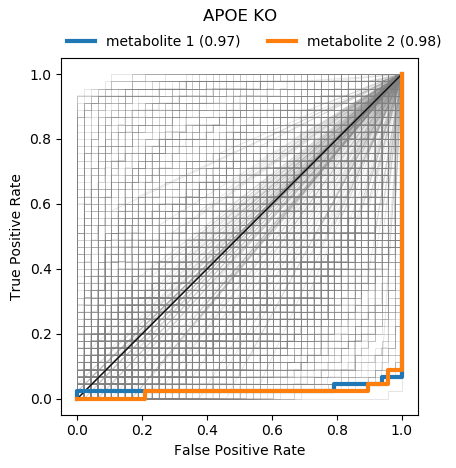

In [77]:
fig_apoe

In [78]:
for n, i in enumerate(fids, 1):
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    if n > 2:
        #ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color='black', alpha=0.5)
        pass
    else:
        ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=plt.cm.tab10.colors[n-1], label='metabolite %d (%.2f)' % (n, a))
ax_ldlr.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_ldlr.tight_layout()

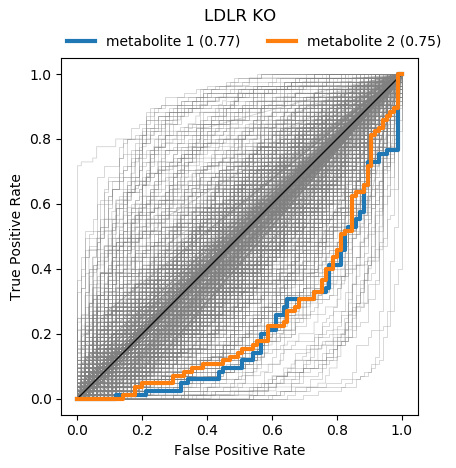

In [79]:
fig_ldlr

In [80]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('roc-metabites2.pdf') as pdf:
    pdf.savefig(fig_apoe)
    pdf.savefig(fig_ldlr)